In [ ]:
# Step 1: Install necessary libraries
!pip install librosa scikit-learn

In [ ]:
# Step 2: Import libraries
import os
import zipfile
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
# Step 3: Upload the zip file manually
uploaded = files.upload()

In [ ]:
# Step 4: Extract the zip file
zip_file_name = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
# Step 5: Load and preprocess the dataset
def load_and_preprocess_data(dataset_path):
    data = []
    labels = []
    label_dict = {}
    current_label = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = os.path.basename(root)

                if label not in label_dict:
                    label_dict[label] = current_label
                    current_label += 1

                y, sr = librosa.load(file_path, sr=None)
                y = librosa.util.fix_length(y, size=22050)  # Standardize length to 1 second at 22050 Hz
                # Compute the Short-Time Fourier Transform (STFT) to create a 2D representation
                stft = np.abs(librosa.stft(y))
                data.append(stft)
                labels.append(label_dict[label])

    data = np.array(data)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(label_dict))

    return data, labels, label_dict

dataset_path = 'dataset'
data, labels, label_dict = load_and_preprocess_data(dataset_path)

In [ ]:
# Step 6: Prepare for K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
all_y_true = []
all_y_pred = []

In [ ]:
# Step 7: Build the CNN model for feature extraction
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = data.shape[1:] + (1,)  # Shape of the STFT data with channel dimension
data = data[..., np.newaxis]  # Add channel dimension

# K-Fold Cross Validation
for train_idx, test_idx in kfold.split(data):
    # Split data
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Build and compile model with specified learning rate
    cnn_model = build_cnn_model(input_shape, len(label_dict))
    optimizer = Adam(learning_rate=0.001)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the CNN model with specified batch size and epochs
    cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Extract features using the CNN model
    feature_extractor = Sequential(cnn_model.layers[:-1])  # Remove the last layer
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Train the SVM classifier
    svm_classifier = SVC(kernel='linear', probability=True)
    svm_classifier.fit(X_train_features, np.argmax(y_train, axis=1))

    # Predict and store results
    y_pred = svm_classifier.predict(X_test_features)
    all_y_true.extend(np.argmax(y_test, axis=1))
    all_y_pred.extend(y_pred)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.2420 - loss: 2.6629
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.4541 - loss: 1.4792
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4790 - loss: 1.3406
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6144 - loss: 0.9960
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6977 - loss: 0.8617
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7347 - loss: 0.7558
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8010 - loss: 0.6039
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8508 - loss: 0.4665
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8430 - loss: 0.4236
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8940 - loss: 0.3589
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9022 - loss: 0.2610
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9057 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.2644 - loss: 2.0316
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4812 - loss: 1.4639
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5898 - loss: 1.1781
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6266 - loss: 1.0002
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7526 - loss: 0.6922
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7476 - loss: 0.6882
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7804 - loss: 0.6045
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8839 - loss: 0.3963
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8982 - loss: 0.3219
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9019 - loss: 0.2891
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9134 - loss: 0.3291
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9227 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2547 - loss: 2.4912
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4359 - loss: 1.4339
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5609 - loss: 1.0696
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6494 - loss: 0.9283
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7601 - loss: 0.6806
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8160 - loss: 0.5320
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8376 - loss: 0.4669
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8620 - loss: 0.3977
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8712 - loss: 0.3305
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9059 - loss: 0.2747
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9346 - loss: 0.2348
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9235 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2262 - loss: 2.0843
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4625 - loss: 1.4683
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5692 - loss: 1.1398
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6568 - loss: 0.9895
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7639 - loss: 0.7298
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7939 - loss: 0.6091
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8531 - loss: 0.4803
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8733 - loss: 0.4135
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8847 - loss: 0.4476
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8499 - loss: 0.4036
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8853 - loss: 0.2962
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8952 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2277 - loss: 2.6648
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4084 - loss: 1.5628
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5587 - loss: 1.2730
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6463 - loss: 0.9893
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6850 - loss: 0.8767
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7632 - loss: 0.6517
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8470 - loss: 0.5138
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8466 - loss: 0.5000
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8813 - loss: 0.3428
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8505 - loss: 0.4631
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8985 - loss: 0.3515
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9124 - lo

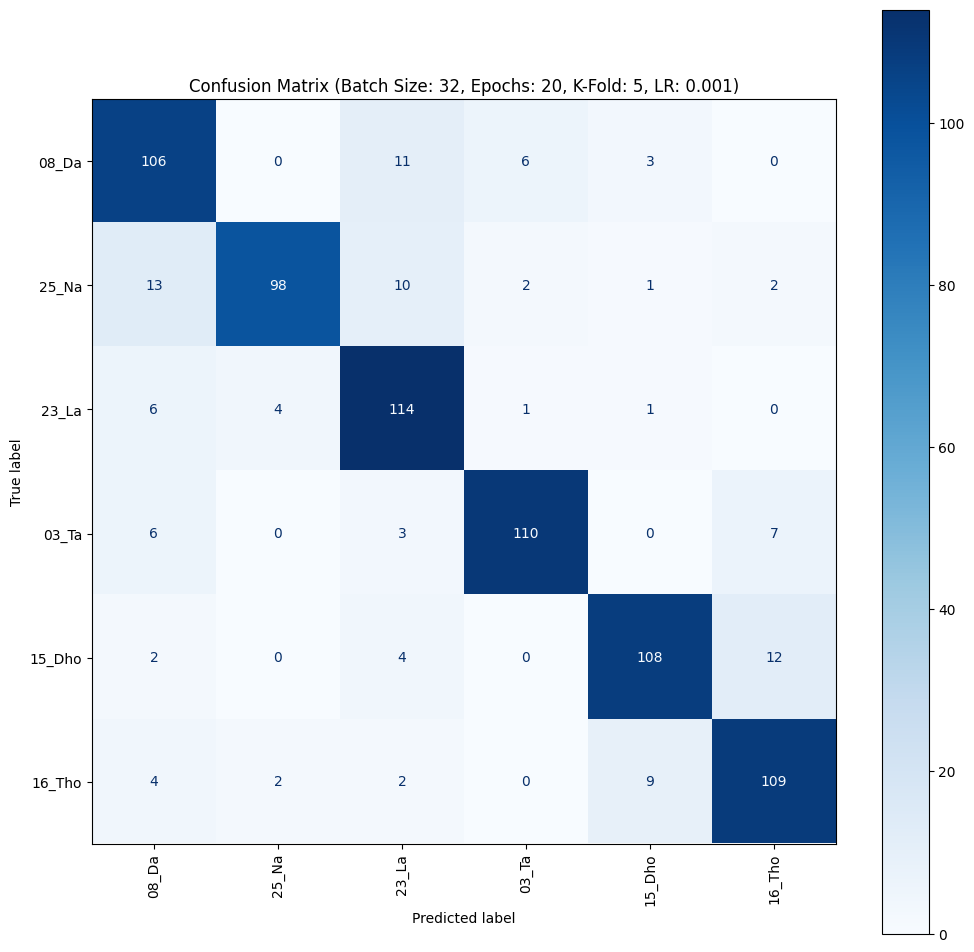

In [ ]:
# Step 8: Generate and display the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_dict.keys()))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix (Batch Size: 32, Epochs: 20, K-Fold: 5, LR: 0.001)")
plt.show()

In [ ]:
# Step 9: Print classification metrics
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=list(label_dict.keys())))

precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
accuracy = accuracy_score(all_y_true, all_y_pred)

print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")



Classification Report:
              precision    recall  f1-score   support

       08_Da       0.77      0.84      0.81       126
       25_Na       0.94      0.78      0.85       126
       23_La       0.79      0.90      0.84       126
       03_Ta       0.92      0.87      0.90       126
      15_Dho       0.89      0.86      0.87       126
      16_Tho       0.84      0.87      0.85       126

    accuracy                           0.85       756
   macro avg       0.86      0.85      0.85       756
weighted avg       0.86      0.85      0.85       756


Overall Metrics:
Accuracy: 85.32%
Precision: 0.86
Recall: 0.85
F1-Score: 0.85
